In [1]:
import math
import numpy as np
import cv2
import scikitplot

import seaborn as sns
import tensorflow as tf
import pandas as pd

from keras.utils import to_categorical
from matplotlib import pyplot

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

from tensorflow.keras import optimizers
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Flatten, Dense, GlobalAvgPool2D, GlobalMaxPool2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model

In [2]:
INPUT_PATH = 'C:/Users/Nikitha/Downloads/data/train'

In [3]:
import os

total_images = 0
for dir_ in os.listdir(INPUT_PATH):
    count = 0
    for f in os.listdir(INPUT_PATH + "/" + dir_ + '/'):
        count += 1
        total_images += 1
    print(f"{dir_} has {count} number of images")

print(f"\ntotal images are {total_images}")

angry has 3995 number of images
disgust has 436 number of images
fear has 4097 number of images
happy has 7215 number of images
neutral has 4965 number of images
sad has 4830 number of images
surprise has 3171 number of images

total images are 28709


In [4]:
TOP_EMOTIONS = ["happy", "neutral", "sad", "fear"]

In [5]:
total_images -= (3171+3995+436)
total_images

21107

In [6]:
img_arr = np.empty(shape=(total_images,48,48,3))
img_label = np.empty(shape=(total_images))
label_to_text = {}

i = 0
e = 0
for dir_ in os.listdir(INPUT_PATH):
    if dir_ in TOP_EMOTIONS:
        label_to_text[e] = dir_
        for f in os.listdir(INPUT_PATH + "/" + dir_ + "/"):
            img_arr[i] = cv2.imread(INPUT_PATH + "/" + dir_ + "/" + f)
            img_label[i] = e
            i += 1
        print(f"loaded all {dir_} images to numpy arrays")
        e += 1

img_arr.shape, img_label

loaded all fear images to numpy arrays
loaded all happy images to numpy arrays
loaded all neutral images to numpy arrays
loaded all sad images to numpy arrays


((21107, 48, 48, 3), array([0., 0., 0., ..., 3., 3., 3.]))

In [7]:
label_to_text

{0: 'fear', 1: 'happy', 2: 'neutral', 3: 'sad'}

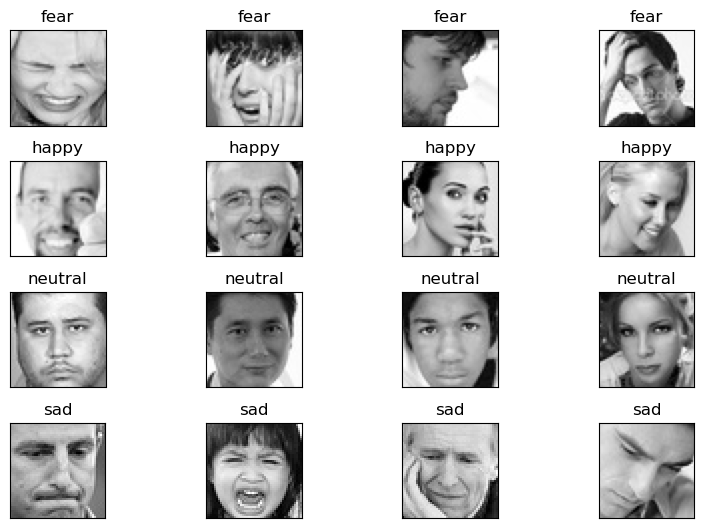

In [8]:
fig = pyplot.figure(1, (8,8))

idx = 0
for k in label_to_text:
    sample_indices = np.random.choice(np.where(img_label==k)[0], size=4, replace=False)
    sample_images = img_arr[sample_indices]
    for img in sample_images:
        if idx < 24:
            idx += 1
        ax = pyplot.subplot(6,4,idx)
        ax.imshow(img[:,:,0], cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(label_to_text[k])
        pyplot.tight_layout()

In [9]:
img_label = to_categorical(img_label)
img_label.shape

(21107, 4)

In [10]:
img_arr = img_arr / 255.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(img_arr, img_label,
                                                    shuffle=True, stratify=img_label,
                                                    train_size=0.9, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((18996, 48, 48, 3), (2111, 48, 48, 3), (18996, 4), (2111, 4))

In [12]:
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]

In [13]:
mobile_net = MobileNet(
    input_shape = (img_width, img_height, img_depth),
    include_top = False,
    weights = "imagenet",
    classes = num_classes
)

x = mobile_net.layers[-14].output
global_pool = GlobalMaxPool2D(name="global_pool")(x)
out = Dense(num_classes, activation="softmax", name="out_layer")(global_pool)

model = Model(inputs=mobile_net.input, outputs=out)
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 conv1 (Conv2D)              (None, 24, 24, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 24, 24, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 24, 24, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 24, 24, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 24, 24, 32)       128       
 ation)                                                      

                                                                 
 conv_pw_8 (Conv2D)          (None, 3, 3, 512)         262144    
                                                                 
 conv_pw_8_bn (BatchNormaliz  (None, 3, 3, 512)        2048      
 ation)                                                          
                                                                 
 conv_pw_8_relu (ReLU)       (None, 3, 3, 512)         0         
                                                                 
 conv_dw_9 (DepthwiseConv2D)  (None, 3, 3, 512)        4608      
                                                                 
 conv_dw_9_bn (BatchNormaliz  (None, 3, 3, 512)        2048      
 ation)                                                          
                                                                 
 conv_dw_9_relu (ReLU)       (None, 3, 3, 512)         0         
                                                                 
 conv_pw_9

In [14]:
plot_model(model, show_shapes=True, show_layer_names=True, expand_nested=True, dpi=50, to_file='mobilenet.png')

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [15]:
for layer in model.layers[:15]:
    layer.trainable = False

In [16]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    zca_whitening=False,
)
train_datagen.fit(X_train)

In [17]:
"""

"""
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00008,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    min_delta=0.0001,
    factor=0.25,
    patience=4,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

In [18]:
batch_size = 25
epochs = 40

optims = [
    optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
    optimizers.Adam(0.01),
]

model.compile(
        loss='categorical_crossentropy',
        optimizer=optims[1],
        metrics=['accuracy']
)

history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_test, y_test),
    steps_per_epoch=len(X_train) / batch_size,
    epochs=epochs,
    callbacks=callbacks,
    use_multiprocessing=False
)

Epoch 1/40
759/759 [==============================] - 105s 129ms/step - loss: 1.3332 - accuracy: 0.4511 - val_loss: 1.1010 - val_accuracy: 0.5741 - lr: 0.0100
Epoch 2/40
759/759 [==============================] - 91s 120ms/step - loss: 1.0624 - accuracy: 0.5547 - val_loss: 1.0706 - val_accuracy: 0.5675 - lr: 0.0100
Epoch 3/40
759/759 [==============================] - 93s 123ms/step - loss: 0.9797 - accuracy: 0.5882 - val_loss: 0.9590 - val_accuracy: 0.6054 - lr: 0.0100
Epoch 4/40
759/759 [==============================] - 89s 117ms/step - loss: 0.9630 - accuracy: 0.5983 - val_loss: 0.9392 - val_accuracy: 0.5817 - lr: 0.0100
Epoch 5/40
759/759 [==============================] - 91s 119ms/step - loss: 0.9365 - accuracy: 0.6112 - val_loss: 0.9154 - val_accuracy: 0.5926 - lr: 0.0100
Epoch 6/40
759/759 [==============================] - 81s 107ms/step - loss: 0.9165 - accuracy: 0.6174 - val_loss: 0.8794 - val_accuracy: 0.6300 - lr: 0.0100
Epoch 7/40
759/759 [==============================]

In [19]:
training_accuracy = history.history['accuracy'][-1]  # assuming accuracy is being logged during training

print("Training Accuracy:", training_accuracy*100)

Training Accuracy: 71.92566990852356


C:\Users\Nikitha\anaconda3\envs\tensorflow\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Nikitha\anaconda3\envs\tensorflow\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Nikitha\anaconda3\envs\tensorflow\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Nikitha\anaconda3\envs\tensorflow\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future

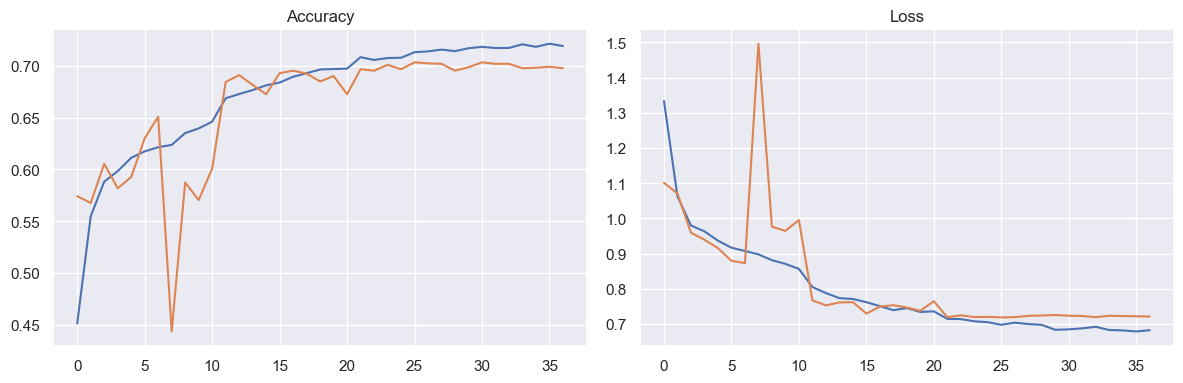

In [20]:
sns.set()
fig = pyplot.figure(0, (12, 4))

ax = pyplot.subplot(1, 2, 1)
sns.lineplot(history.history['accuracy'])
sns.lineplot(history.history['val_accuracy'])
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.lineplot(history.history['loss'])
sns.lineplot(history.history['val_loss'])
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('epoch_history_mobilenet.png')
pyplot.show()

66/66 [==============================] - 4s 24ms/step
test accuracy: 70.3458 %




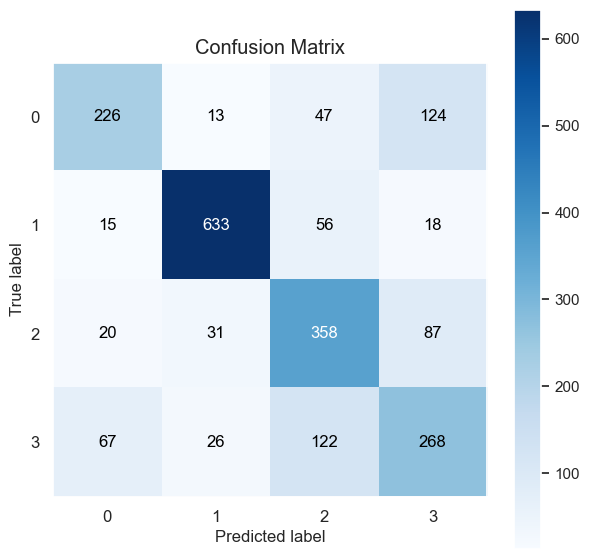

In [21]:
yhat_test = np.argmax(model.predict(X_test), axis=1)
ytest_ = np.argmax(y_test, axis=1)

scikitplot.metrics.plot_confusion_matrix(ytest_, yhat_test, figsize=(7,7))
pyplot.savefig("confusion_matrix_mobilenet.png")

test_accu = np.sum(ytest_ == yhat_test) / len(ytest_) * 100
print(f"test accuracy: {round(test_accu, 4)} %\n\n")

In [22]:
print(classification_report(ytest_, yhat_test))

              precision    recall  f1-score   support

           0       0.69      0.55      0.61       410
           1       0.90      0.88      0.89       722
           2       0.61      0.72      0.66       496
           3       0.54      0.55      0.55       483

    accuracy                           0.70      2111
   macro avg       0.69      0.68      0.68      2111
weighted avg       0.71      0.70      0.70      2111

